https://www.kaggle.com/anokas/mercedes-eda-xgboost-starter-0-55

In [44]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pal = sns.color_palette()

print('# File sizes')
for f in os.listdir('../input'):
    if 'zip' not in f:
        print(f.ljust(30) + str(round(os.path.getsize('../input/' + f) / 1000000, 2)) + 'MB')

# File sizes
test.csv                      3.19MB
train.csv                     3.22MB
sample_submission.csv         0.09MB


In [3]:
TRAIN_PATH='../input/train.csv'
TEST_PATH='../input/test.csv'
SAMPLE_PATH='../input/sample_submission.csv'

In [4]:
train=pd.read_csv(TRAIN_PATH)
test=pd.read_csv(TEST_PATH)
sample=pd.read_csv(SAMPLE_PATH)

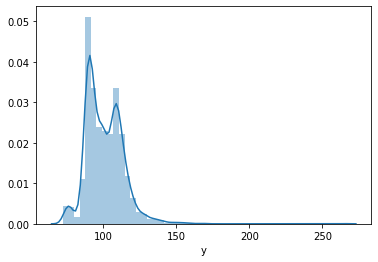

In [6]:
sns.distplot(train.y)
plt.show()

In [45]:
y_train=train['y']

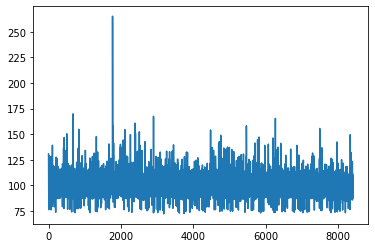

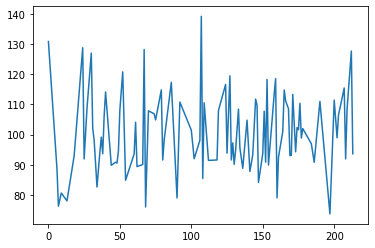

In [14]:
plt.plot(train['ID'],y_train)
plt.show()
plt.plot(train['ID'][:100],y_train[:100])
plt.show()

In [46]:
cols=[c for c in train.columns if 'X' in c]
df_train.dtypes.value_counts()

int64      369
object       8
float64      1
dtype: int64

In [47]:
counts = [[], [], []]
for c in cols:
    typ = train[c].dtype
    uniq = len(np.unique(train[c]))
    if uniq == 1: counts[0].append(c)
    elif uniq == 2 and typ == np.int64: counts[1].append(c)
    else: counts[2].append(c)

print('Constant features: {} Binary features: {} Categorical features: {}\n'.format(*[len(c) for c in counts]))

print('Constant features:', counts[0])
print('Categorical features:', counts[2])

Constant features: 12 Binary features: 356 Categorical features: 8

Constant features: ['X11', 'X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290', 'X293', 'X297', 'X330', 'X347']
Categorical features: ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8']


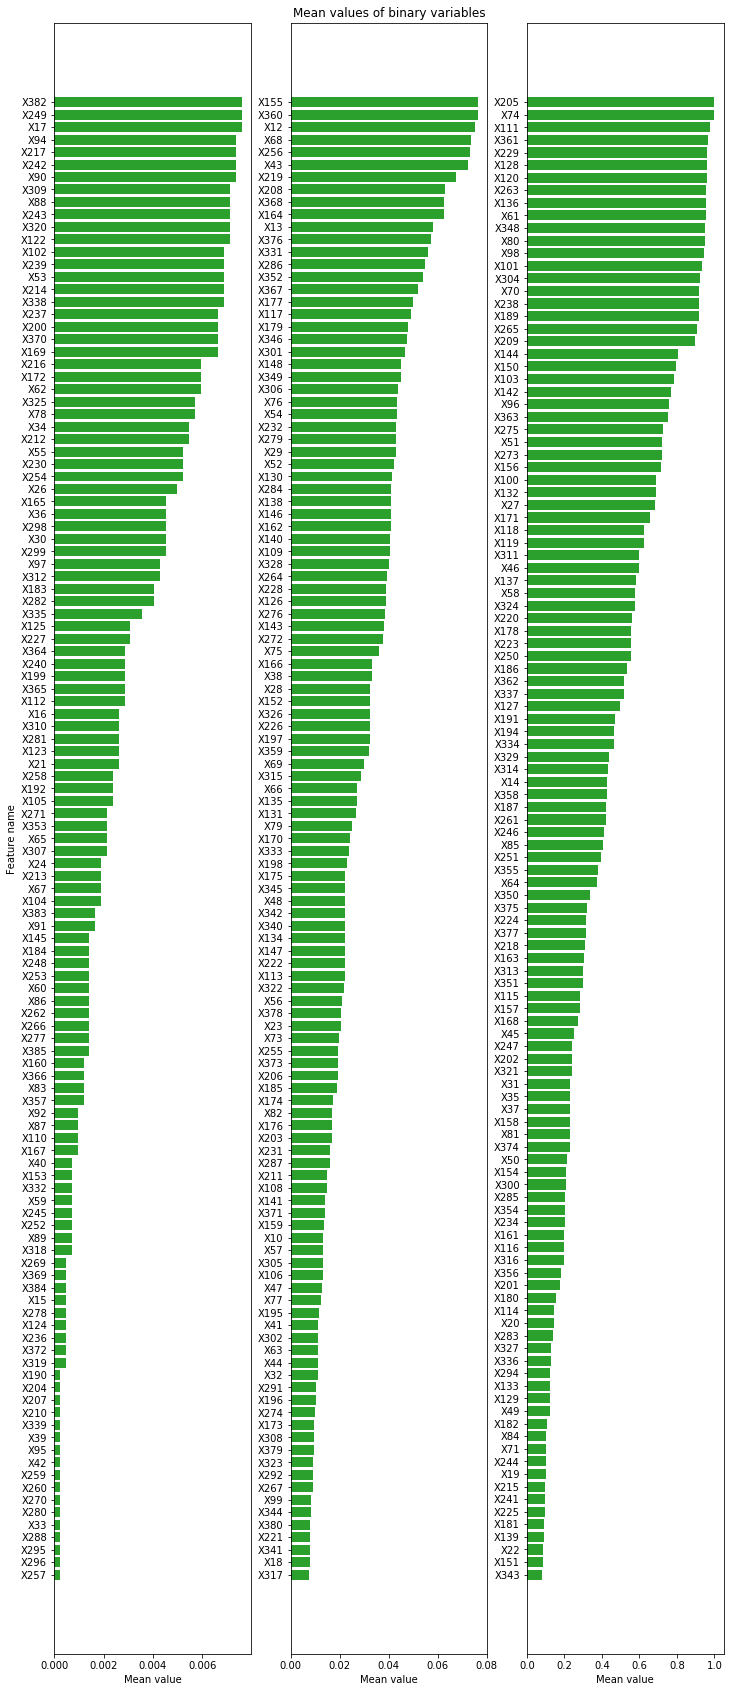

In [23]:
binary_means = [np.mean(df_train[c]) for c in counts[1]]
binary_names = np.array(counts[1])[np.argsort(binary_means)]
binary_means = np.sort(binary_means)

fig, ax = plt.subplots(1, 3, figsize=(12,30))
ax[0].set_ylabel('Feature name')
ax[1].set_title('Mean values of binary variables')
for i in range(3):
    names, means = binary_names[i*119:(i+1)*119], binary_means[i*119:(i+1)*119]
    ax[i].barh(range(len(means)), means, color=pal[2])
    ax[i].set_xlabel('Mean value')
    ax[i].set_yticks(range(len(means)))
    ax[i].set_yticklabels(names, rotation='horizontal')
plt.show()

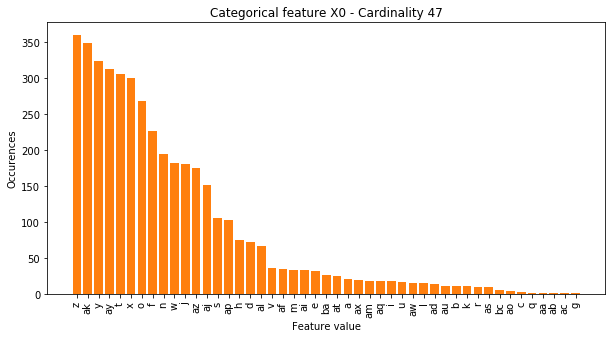

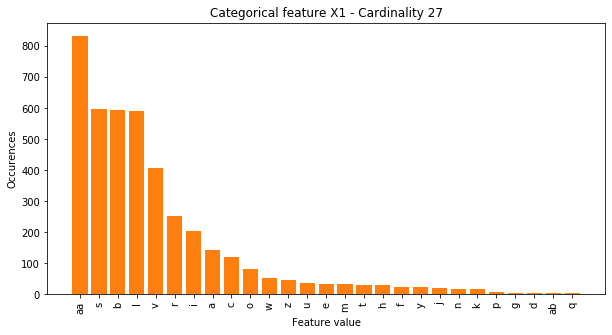

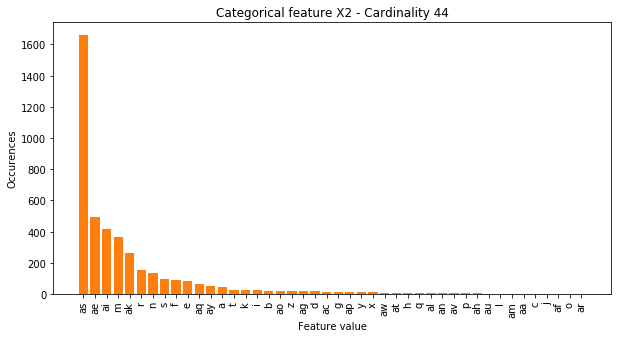

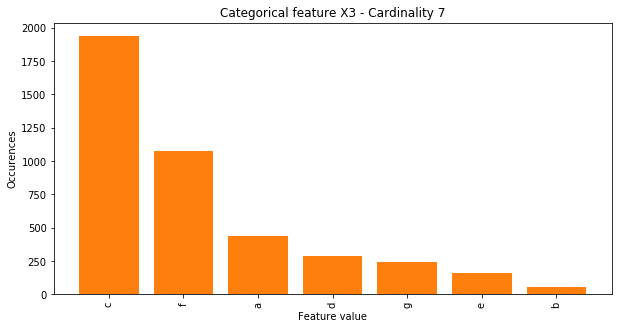

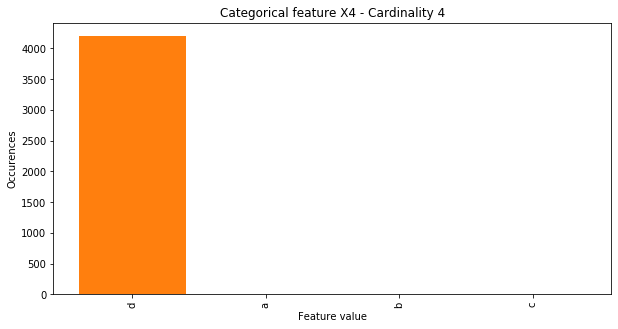

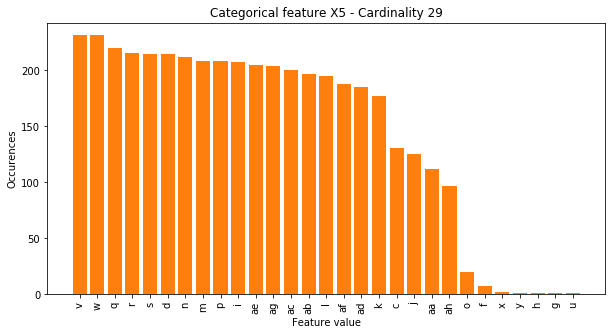

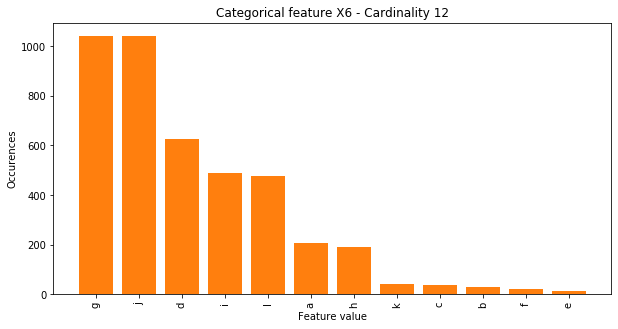

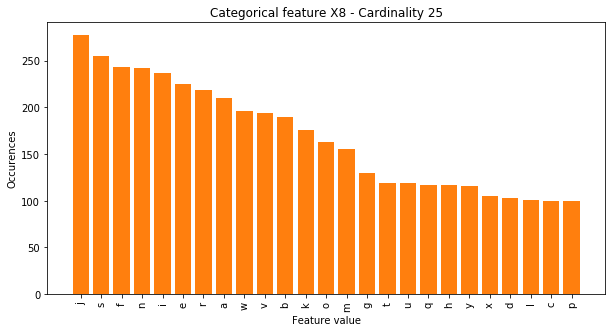

In [24]:
for c in counts[2]:
    value_counts = df_train[c].value_counts()
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.title('Categorical feature {} - Cardinality {}'.format(c, len(np.unique(df_train[c]))))
    plt.xlabel('Feature value')
    plt.ylabel('Occurences')
    plt.bar(range(len(value_counts)), value_counts.values, color=pal[1])
    ax.set_xticks(range(len(value_counts)))
    ax.set_xticklabels(value_counts.index, rotation='vertical')
    plt.show()

In [48]:
df_test = pd.read_csv('../input/test.csv')

usable_columns = list(set(df_train.columns) - set(['ID', 'y']))

y_train = df_train['y'].values
id_test = df_test['ID'].values

x_train = df_train[usable_columns]
x_test = df_test[usable_columns]

for column in usable_columns:
    cardinality = len(np.unique(x_train[column]))
    if cardinality == 1:
        x_train.drop(column, axis=1) # Column with only one value is useless so we drop it
        x_test.drop(column, axis=1)
    if cardinality > 2: # Column is categorical
        mapper = lambda x: sum([ord(digit) for digit in x])
        x_train[column] = x_train[column].apply(mapper)
        x_test[column] = x_test[column].apply(mapper)
        
x_train.head()

/home/nagae/.conda/envs/gpu-env/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/nagae/.conda/envs/gpu-env/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,X230,X103,X20,X336,X250,X91,X342,X219,X306,X365,...,X274,X99,X235,X208,X301,X264,X248,X63,X281,X168
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)
d_test = xgb.DMatrix(x_test)

params = {}
params['objective'] = 'reg:linear'
params['eta'] = 0.02
params['max_depth'] = 4

def xgb_r2_score(preds, dtrain):
    labels = dtrain.get_label()
    return 'r2', r2_score(labels, preds)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

clf = xgb.train(params, d_train, 1000, watchlist, early_stopping_rounds=50, feval=xgb_r2_score, maximize=True, verbose_eval=10)

[18:04:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:99.1397	valid-rmse:98.2538	train-r2:-58.3426	valid-r2:-67.6247
Multiple eval metrics have been passed: 'valid-r2' will be used for early stopping.

Will train until valid-r2 hasn't improved in 50 rounds.
[10]	train-rmse:81.1832	valid-rmse:80.2714	train-r2:-38.7928	valid-r2:-44.804
[20]	train-rmse:66.541	valid-rmse:65.5967	train-r2:-25.7332	valid-r2:-29.5876
[30]	train-rmse:54.6149	valid-rmse:53.6305	train-r2:-17.0092	valid-r2:-19.4459
[40]	train-rmse:44.9172	valid-rmse:43.8842	train-r2:-11.1814	valid-r2:-12.6899
[50]	train-rmse:37.0508	valid-rmse:35.9587	train-r2:-7.28831	valid-r2:-8.19158
[60]	train-rmse:30.6913	valid-rmse:29.5289	train-r2:-4.68723	valid-r2:-5.19837
[70]	train-rmse:25.5745	valid-rmse:24.3342	train-r2:-2.949	valid-r2:-3.20936
[80]	train-rmse:21.4844	valid-rmse:20.1622	train-r2:-1.78687	valid-r2:-1.88973
[90]	train-rmse:18.2427	va

In [43]:
p_test = clf.predict(d_test)

sub = pd.DataFrame()
sub['ID'] = id_test
sub['y'] = p_test
sub.to_csv('xgb.csv', index=False)

In [49]:
from sklearn.model_selection import GridSearchCV
xgb_reg=xgb.XGBRegressor(max_depth=4,eta=0.02)
grid_dict=[{'max_depth':[2,4,6],'n_estimators':[50,100,200]}]
model=GridSearchCV(estimator=xgb_reg,param_grid=grid_dict,verbose=1)
model.fit(x_train,y_train)

p_test = model.predict(x_test)

sub = pd.DataFrame()
sub['ID'] = id_test
sub['y'] = p_test
sub.to_csv('xgb_grid.csv', index=False)

/home/nagae/.conda/envs/gpu-env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 9 candidates, totalling 27 fits
[18:07:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:07:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:07:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:07:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:07:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:07:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:07:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:07:53] WARNING: /workspace/src/objective/regres

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  1.3min finished


[18:09:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


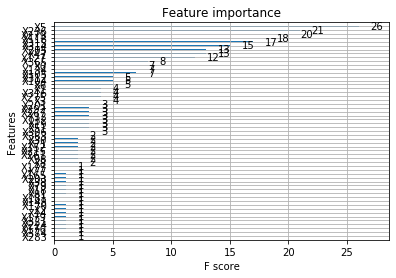

In [36]:
xgb.plot_importance(model.best_estimator_)